In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:\\Users\\mehas\\Downloads\\daily_forex_rates_.csv")
data

,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,334.894713,30-01-2025
1,GHS,EUR,Ghanaian Cedi,15.857993,30-01-2025
2,HRK,EUR,Croatian Kuna,7.675077,30-01-2025
3,HNL,EUR,Honduran Lempira,26.442220,30-01-2025
4,HKD,EUR,Hong Kong Dollar,8.102892,30-01-2025
...,...,...,...,...,...
399901,JPY,EUR,Japanese Yen,133.350000,01-09-2004
399902,CAD,EUR,Canadian Dollar,1.596700,31-08-2004
399903,JPY,EUR,Japanese Yen,132.850000,31-08-2004
399904,AUD,EUR,Australian Dollar,1.729600,31-08-2004


#  Data Exploration and Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399906 entries, 0 to 399905
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   currency       399906 non-null  object 
 1   base_currency  399906 non-null  object 
 2   currency_name  399906 non-null  object 
 3   exchange_rate  399906 non-null  float64
 4   date           399906 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.3+ MB


In [5]:
data.describe()

,exchange_rate
count,3.999060e+05
mean,6.992209e+03
std,1.440644e+05
min,9.730000e-06
25%,2.589800e+00
50%,1.744678e+01
75%,1.560691e+02
max,4.881841e+06


In [6]:
data.dtypes

currency          object
base_currency     object
currency_name     object
exchange_rate    float64
date              object
dtype: object

In [7]:
data.columns

Index(['currency', 'base_currency', 'currency_name', 'exchange_rate', 'date'], dtype='object')

In [8]:
data.shape

(399906, 5)

In [9]:
data.size

1999530

In [10]:
data.isnull().sum()

currency         0
base_currency    0
currency_name    0
exchange_rate    0
date             0
dtype: int64

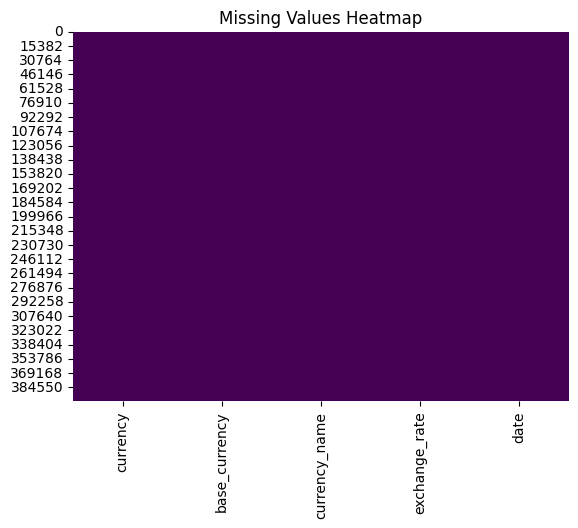

In [11]:
# visualizing missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Exploratory Data Analysis (EDA) and Visualization

In [13]:
# Encode Categorical Columns
currency = LabelEncoder()
base_currency = LabelEncoder()
currency_name = LabelEncoder()

In [14]:
data['currency'] = currency.fit_transform(data['currency'])
data['base_currency'] = base_currency.fit_transform(data['base_currency'])
data['currency_name'] = currency_name.fit_transform(data['currency_name'])

In [15]:
# Standardize Numerical Features
scaler = StandardScaler()
data[['exchange_rate']] = scaler.fit_transform(data[['exchange_rate']])

In [16]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y', errors='coerce')

In [17]:
corr = data.corr()
corr

,currency,base_currency,currency_name,exchange_rate,date
currency,1.000000,NaN,0.838161,0.060022,0.077126
base_currency,NaN,NaN,NaN,NaN,NaN
currency_name,0.838161,NaN,1.000000,0.059271,0.036066
exchange_rate,0.060022,NaN,0.059271,1.000000,0.038331
date,0.077126,NaN,0.036066,0.038331,1.000000


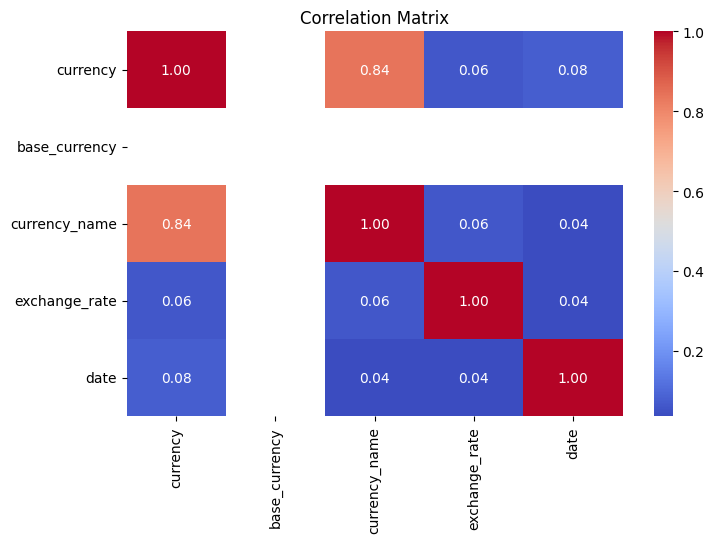

In [18]:
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [19]:
 data.sort_values(by='date', inplace=True)

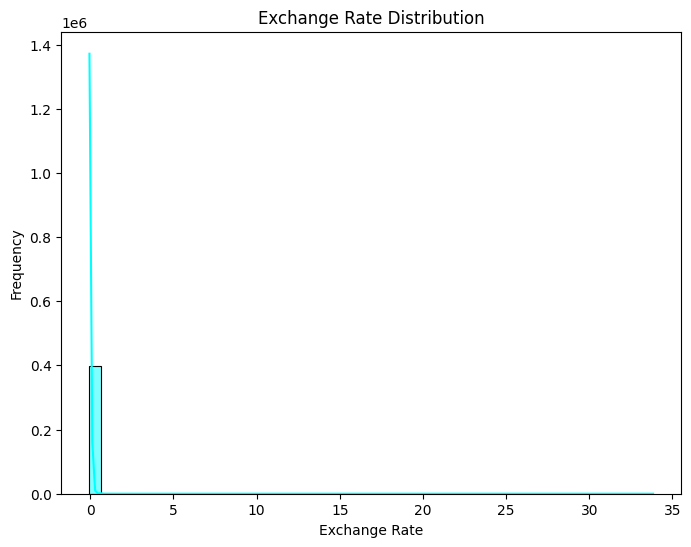

In [20]:
# Exchange Rate Distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['exchange_rate'], kde=True, bins=50, color='cyan')
plt.title("Exchange Rate Distribution")
plt.xlabel("Exchange Rate")
plt.ylabel("Frequency")
plt.show()

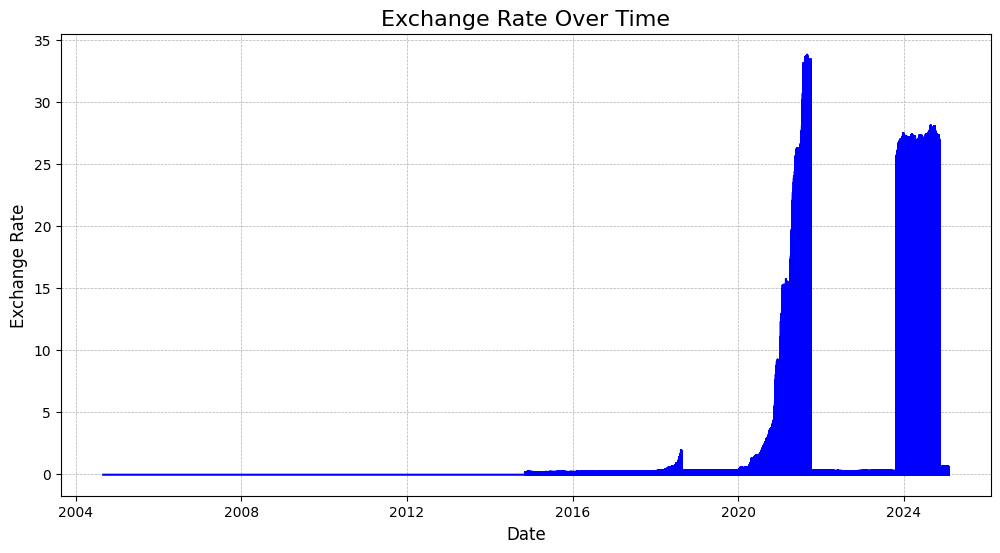

In [21]:
# Plot exchange rates over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['exchange_rate'], color='blue')
plt.title("Exchange Rate Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Exchange Rate", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [22]:
data.fillna(data.mean(), inplace=True)

# Feature Selection

In [24]:
# Selecting Features and Target Variable
x = data.drop(columns=['exchange_rate', 'date'])
y = data['exchange_rate']

In [25]:
x,y

(        currency  base_currency  currency_name
 399905         7              0              7
 399902        27              0             30
 399904         7              0              7
 399903        74              0             74
 399899        27              0             30
 ...          ...            ...            ...
 110          170              0            166
 109          152              0            159
 108          151              0            156
 116          164              0            140
 0            171              0            168
 
 [399906 rows x 3 columns],
 399905   -0.048523
 399902   -0.048524
 399904   -0.048523
 399903   -0.047613
 399899   -0.048524
             ...   
 110      -0.048334
 109      -0.048528
 108      -0.021945
 116      -0.048530
 0        -0.046211
 Name: exchange_rate, Length: 399906, dtype: float64)

# Train-Test Split

In [27]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.32, random_state=42)

# Stationarity Testing

In [29]:
# ADF Test for Stationarity
adf_test = adfuller(data['exchange_rate'])

In [30]:
# Print results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

ADF Statistic: -59.472229118899484
p-value: 0.0
Critical Values: {'1%': -3.4303663561650324, '5%': -2.8615472292284325, '10%': -2.566773847854915}


In [31]:
# Interpretation
if adf_test[1] < 0.05:
    print("The data is stationary (No trend detected).")
else:
    print("The data is NOT stationary (Apply differencing).")

The data is stationary (No trend detected).


# ARIMA Model Training

In [33]:
# ARIMA MODEL TRAINING
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])  # Ensure it's in datetime format
    data.set_index('date', inplace=True)

In [34]:
# Find the Best ARIMA Order
best_arima_model = auto_arima(data['exchange_rate'], seasonal=False, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1673.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1412619.363, Time=11.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1297545.524, Time=13.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=534.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1412617.363, Time=5.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1250476.258, Time=230.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1224669.589, Time=58.64 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1208357.076, Time=73.85 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1197090.360, Time=165.85 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1544.94 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=889.07 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1197088.360, Time=44.20 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1208355.076, Time=38.87 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=289.39 sec
 ARIMA(4,

In [35]:
# Extract the best (p,d,q) values
best_order = best_arima_model.order
print(f"Optimal ARIMA Order: {best_order}")  

Optimal ARIMA Order: (5, 1, 0)


In [36]:
arima_model = ARIMA(data['exchange_rate'], order=best_order)

In [37]:
arima_result = arima_model.fit()

In [38]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:          exchange_rate   No. Observations:               399906
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -598538.180
Date:                Sat, 01 Feb 2025   AIC                        1197088.360
Time:                        17:04:22   BIC                        1197153.754
Sample:                             0   HQIC                       1197107.045
                             - 399906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8333      0.000  -2261.918      0.000      -0.834      -0.833
ar.L2         -0.6665      0.000  -1430.399      0.000      -0.667      -0.666
ar.L3         -0.4999      0.000  -1011.416      0.0

In [39]:
# Forecast with ARIMA
forecast_steps = 30
arima_forecast = arima_result.forecast(steps=forecast_steps)

In [72]:
print("ARIMA Forecast:")
print(arima_forecast)

ARIMA Forecast:
399906   -0.032851
399907   -0.041066
399908   -0.039855
399909   -0.038409
399910   -0.041153
399911   -0.039925
399912   -0.038877
399913   -0.039881
399914   -0.039683
399915   -0.039655
399916   -0.039862
399917   -0.039647
399918   -0.039601
399919   -0.039721
399920   -0.039695
399921   -0.039697
399922   -0.039704
399923   -0.039677
399924   -0.039683
399925   -0.039696
399926   -0.039692
399927   -0.039691
399928   -0.039691
399929   -0.039688
399930   -0.039690
399931   -0.039691
399932   -0.039691
399933   -0.039690
399934   -0.039690
399935   -0.039690
Name: predicted_mean, dtype: float64


In [74]:
# Forecast for training data (for evaluation)
y_train_pred = arima_result.fittedvalues

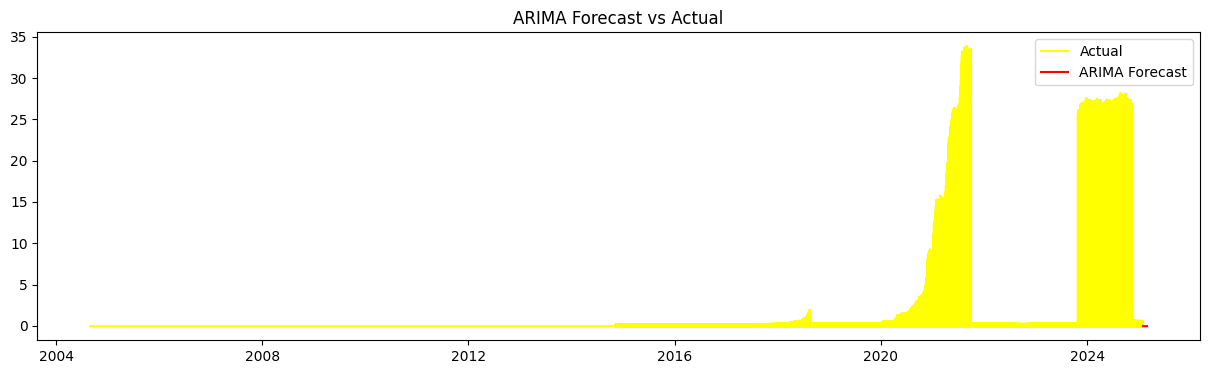

In [76]:
# Arima Model Forecast
plt.figure(figsize=(15,4))
plt.plot(data.index, data['exchange_rate'], label="Actual", color='yellow')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps+1, freq='D')[1:], 
         arima_forecast, label="ARIMA Forecast", color='red')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

In [77]:
data.tail()

,currency,base_currency,currency_name,exchange_rate
date,,,,
2025-01-30,170,0,166,-0.048334
2025-01-30,152,0,159,-0.048528
2025-01-30,151,0,156,-0.021945
2025-01-30,164,0,140,-0.048530
2025-01-30,171,0,168,-0.046211


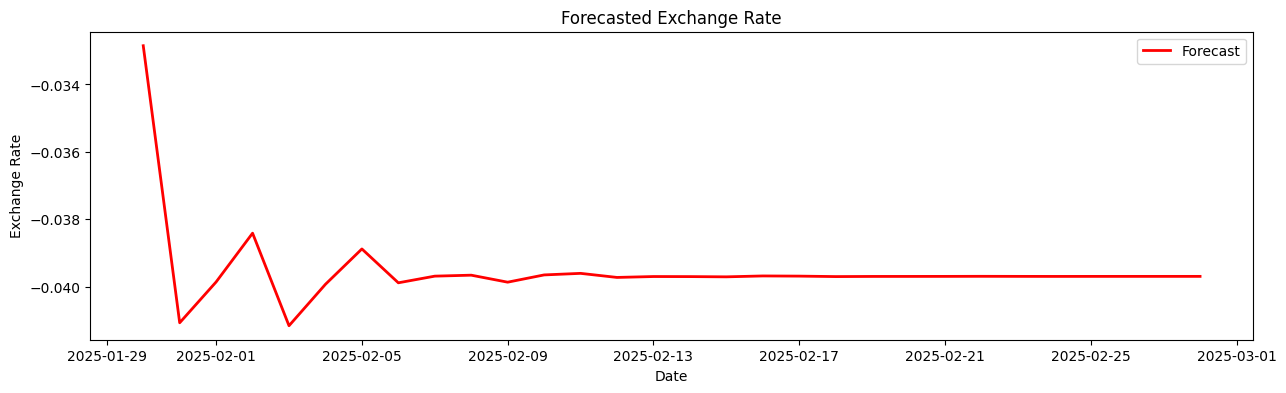

In [84]:
# Forecast Exchange Rates
plt.figure(figsize=(15, 4))
forecast_index = pd.date_range(start=data.index[-1], periods=30, freq='D')
plt.plot(forecast_index, arima_forecast, label='Forecast', color='red', linewidth=2)
plt.title("Forecasted Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [86]:
# R² Score
r2 = r2_score(data['exchange_rate'][1:], y_train_pred[1:])
print(f"R² Score: {r2}")

R² Score: -0.16826497178499022


In [88]:
# RMSE Score
rmse = np.sqrt(mean_squared_error(data['exchange_rate'][1:], y_train_pred[1:]))
print(f"RMSE: {rmse}")

RMSE: 1.0808644162256558


In [90]:
# MAE Score
mae = mean_absolute_error(data['exchange_rate'][1:], y_train_pred[1:])
print(f"MAE: {mae}")

MAE: 0.09399493153137532


In [92]:
# Check residuals
residuals = arima_result.resid

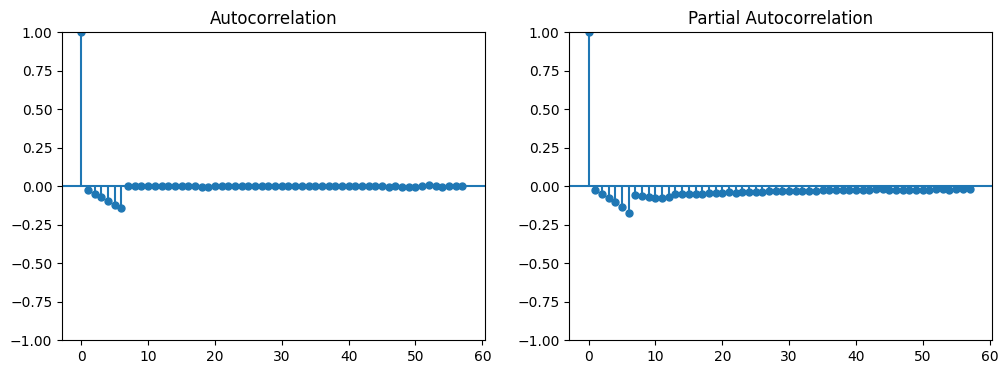

In [94]:
# Plot ACF and PACF for residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1])
plt.show()

In [95]:
# Print residuals summary statistics
print(residuals.describe())

count    3.999060e+05
mean    -4.430077e-08
std      1.080864e+00
min     -5.659212e+00
25%     -9.411760e-03
50%     -1.565613e-03
75%     -3.977887e-05
max      3.388650e+01
dtype: float64


# LSTM Model Training

In [96]:
# Preparing Data for LSTM
sequence_length = 10
x,y = [], []
data_values = data[['exchange_rate']].values

In [97]:
for i in range(len(data_values) - sequence_length):
    x.append(data_values[i:i+sequence_length])
    y.append(data_values[i+sequence_length])

In [98]:
x, y = np.array(x), np.array(y)

In [99]:
# Reshape input for LSTM
x = x.reshape((x.shape[0], x.shape[1], 1))

In [100]:
# Splitting data into training and testing
train_size = int(len(x) * 0.8)  # 80% Training, 20% Testing
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [101]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

In [102]:
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [108]:
# Train the Model
lstm_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
7998/7998 [==============================] - 124s 15ms/step - loss: 0.4639 - val_loss: 0.0018
Epoch 2/10
7998/7998 [==============================] - 121s 15ms/step - loss: 0.4639 - val_loss: 0.0014
Epoch 3/10
7998/7998 [==============================] - 120s 15ms/step - loss: 0.4639 - val_loss: 0.0032
Epoch 4/10
7998/7998 [==============================] - 120s 15ms/step - loss: 0.4639 - val_loss: 0.0016
Epoch 5/10
7998/7998 [==============================] - 120s 15ms/step - loss: 0.4639 - val_loss: 0.0017
Epoch 6/10
7998/7998 [==============================] - 120s 15ms/step - loss: 0.4639 - val_loss: 0.0027
Epoch 7/10
7998/7998 [==============================] - 120s 15ms/step - loss: 0.4639 - val_loss: 0.0016
Epoch 8/10
7998/7998 [==============================] - 120s 15ms/step - loss: 0.4639 - val_loss: 0.0017
Epoch 9/10
7998/7998 [==============================] - 125s 16ms/step - loss: 0.4639 - val_loss: 0.0028
Epoch 10/10
7998/7998 [==============================] 

In [116]:
# Evaluate LSTM Model
lstm_predictions = lstm_model.predict(x_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions) 
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, lstm_predictions)))

2500/2500 [==============================] - 14s 5ms/step
LSTM RMSE: 2614.844903793652


In [118]:
# Make predictions
y_pred = lstm_model.predict(x_test)

2500/2500 [==============================] - 14s 6ms/step


In [119]:
# Reverse scaling
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [120]:
forecast_steps = 30  # Set this to the number of days you want to forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

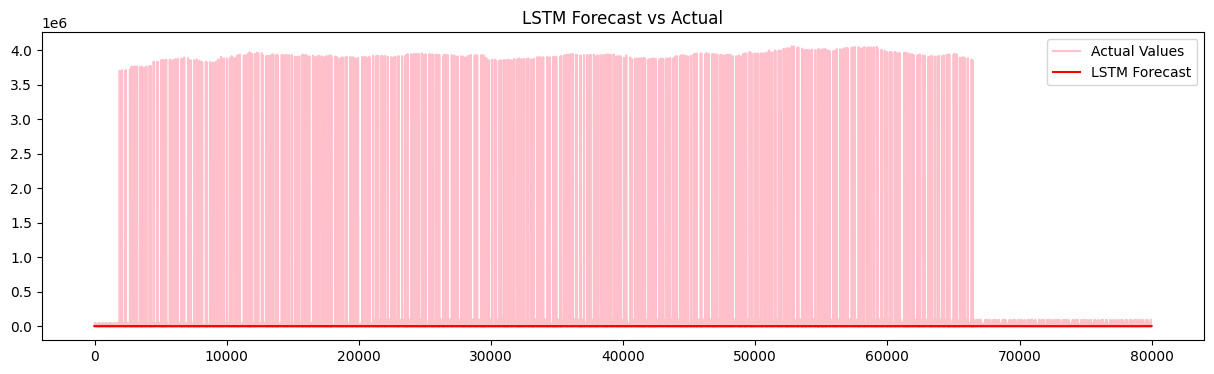

In [121]:
# LSTM Model Forecast
plt.figure(figsize=(15,4))
plt.plot(y_test_original, label='Actual Values', color='pink')
plt.plot(y_pred_original, label='LSTM Forecast', color='red')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()

In [130]:
# R² Score
lstm_r2 = r2_score(y_test, lstm_predictions)
print("LSTM R² Score:", lstm_r2)

LSTM R² Score: -1951660.5341653028


In [134]:
# RMSE Score
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
print("LSTM RMSE:", lstm_rmse)

LSTM RMSE: 2614.844903793652


In [136]:
# MAE Score
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
print("LSTM MAE:", lstm_mae)

LSTM MAE: 2595.6719817166554


# Final Analysis and Findings

### Model Evaluation and Insights

In [138]:
lstm_mse = mean_squared_error(y_test_original, y_pred_original)
lstm_rmse = np.sqrt(lstm_mse)

In [140]:
arima_mse = mean_squared_error(data['exchange_rate'][-forecast_steps:], arima_forecast)
arima_rmse = np.sqrt(arima_mse)

In [142]:
# Print RMSE for both models
print(f"LSTM RMSE: {lstm_rmse}")
print(f"ARIMA RMSE: {arima_rmse}")

LSTM RMSE: 270254.49759959296
ARIMA RMSE: 0.03752103629544379


In [144]:
# Conclusion: Which model performed better
if lstm_rmse < arima_rmse:
    print("LSTM performed better for this dataset.")
else:
    print("ARIMA performed better for this dataset.")

ARIMA performed better for this dataset.


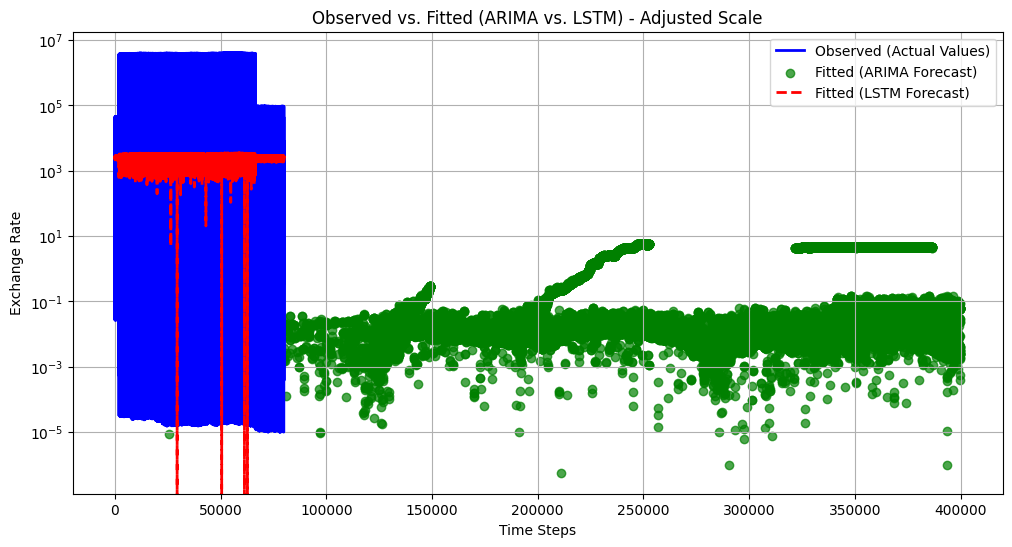

In [208]:
plt.figure(figsize=(12, 6))

# Plot Observed Values (Line Plot)
plt.plot(y_test_original, label='Observed (Actual Values)', color='blue', linestyle='solid', linewidth=2)

# Plot ARIMA Fitted Values (Scatter Plot)
plt.scatter(range(len(arima_result.fittedvalues)), arima_result.fittedvalues, 
            label='Fitted (ARIMA Forecast)', color='green', marker='o', alpha=0.7)

# Plot LSTM Fitted Values (Dashed Line)
plt.plot(y_pred_original, label='Fitted (LSTM Forecast)', color='red', linestyle='dashed', linewidth=2)

# Labels
plt.xlabel("Time Steps")
plt.ylabel("Exchange Rate")
plt.yscale("log")  # Apply log scale to Y-axis
plt.title("Observed vs. Fitted (ARIMA vs. LSTM) - Adjusted Scale")
plt.legend()
plt.grid(True)
plt.show()